In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

df = pd.read_csv("csvs/pokemon.csv")

df.drop(columns=["#"], inplace=True)

df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        800 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   Total       800 non-null    int64 
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


<Axes: >

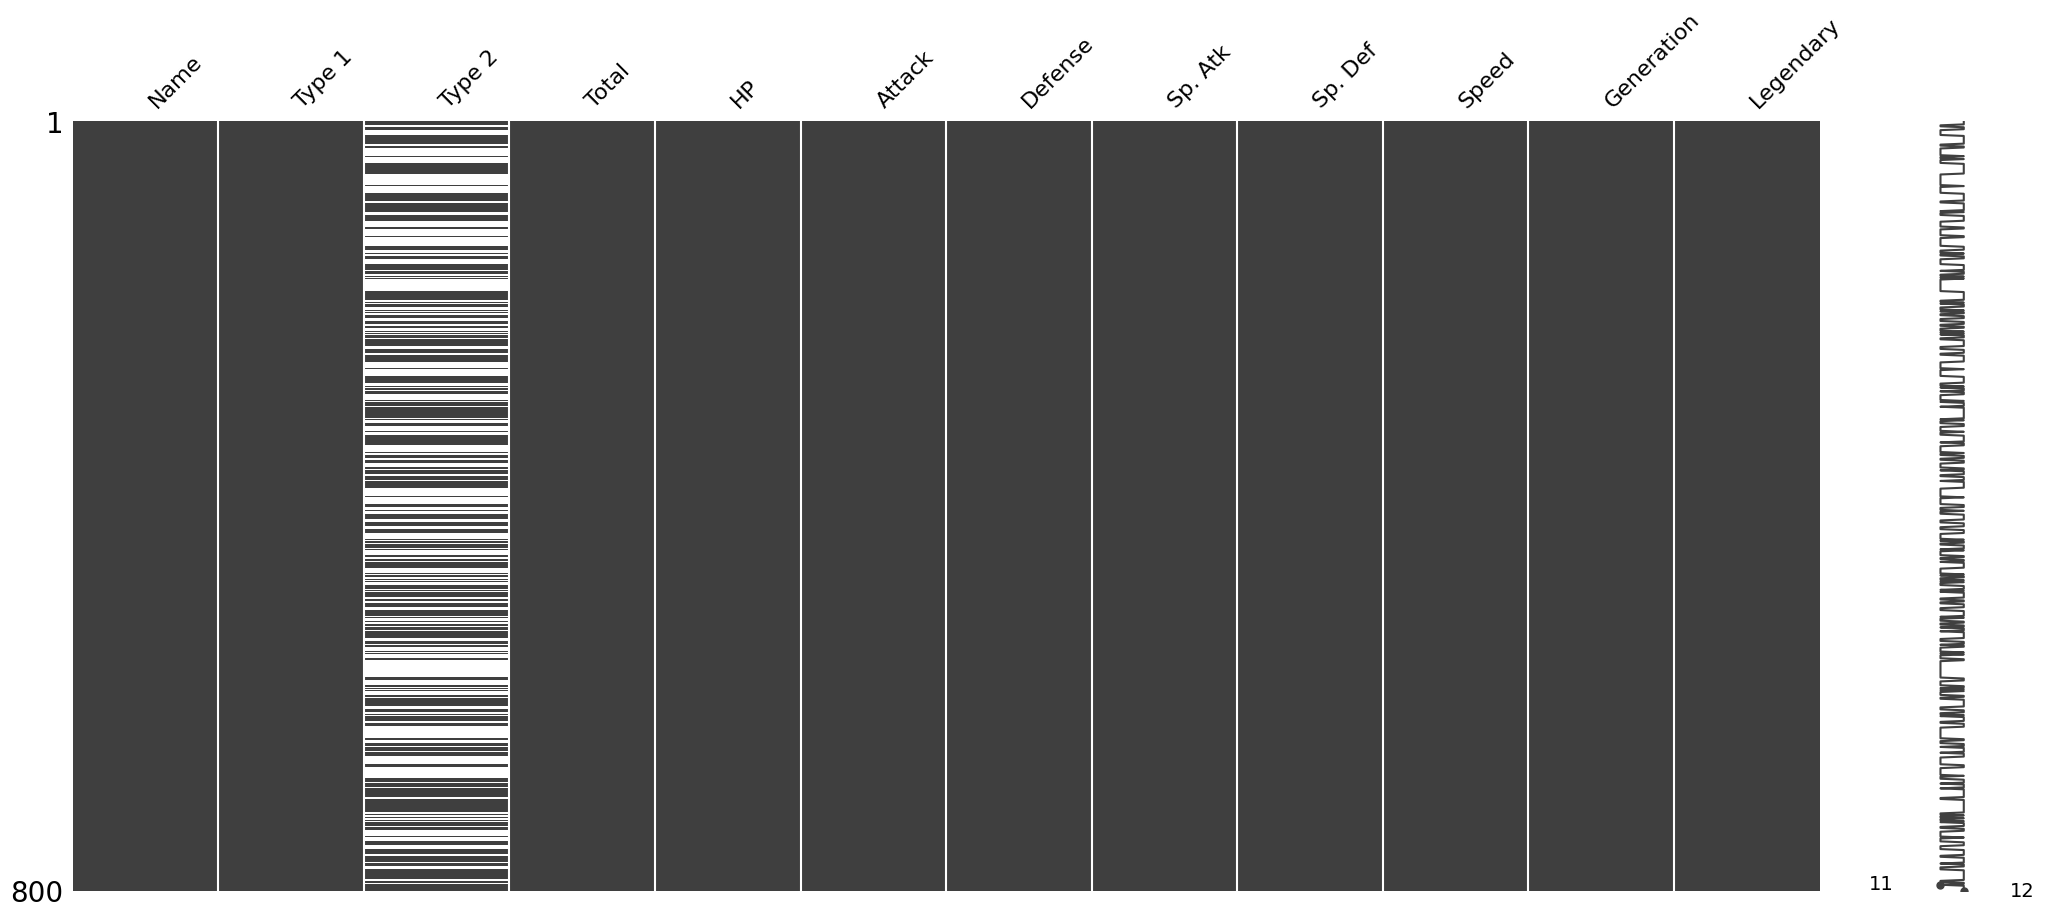

In [25]:
import missingno as msno
msno.matrix(df)

## Preprossecing

In [26]:
df.fillna("None", inplace=True)

There are missing values in "Type 2" column, but this is normal, as there are pokemons with only one type. 


In [27]:
df.nunique() 

Name          800
Type 1         18
Type 2         19
Total         200
HP             94
Attack        111
Defense       103
Sp. Atk       105
Sp. Def        92
Speed         108
Generation      6
Legendary       2
dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])

df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,80,9,14,318,45,49,49,65,65,45,1,False
1,329,9,14,405,60,62,63,80,80,60,1,False
2,745,9,14,525,80,82,83,100,100,80,1,False
3,746,9,14,625,80,100,123,122,120,80,1,False
4,102,6,12,309,39,52,43,60,50,65,1,False


(Couldn't get OneHotEncoder to work)

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="constant", fill_value=0)

df["Type 2"] = imputer.fit_transform(df[["Type 2"]])

df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,80,9,14,318,45,49,49,65,65,45,1,False
1,329,9,14,405,60,62,63,80,80,60,1,False
2,745,9,14,525,80,82,83,100,100,80,1,False
3,746,9,14,625,80,100,123,122,120,80,1,False
4,102,6,12,309,39,52,43,60,50,65,1,False


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Name        800 non-null    int64
 1   Type 1      800 non-null    int64
 2   Type 2      800 non-null    int64
 3   Total       800 non-null    int64
 4   HP          800 non-null    int64
 5   Attack      800 non-null    int64
 6   Defense     800 non-null    int64
 7   Sp. Atk     800 non-null    int64
 8   Sp. Def     800 non-null    int64
 9   Speed       800 non-null    int64
 10  Generation  800 non-null    int64
 11  Legendary   800 non-null    bool 
dtypes: bool(1), int64(11)
memory usage: 69.7 KB


<Axes: >

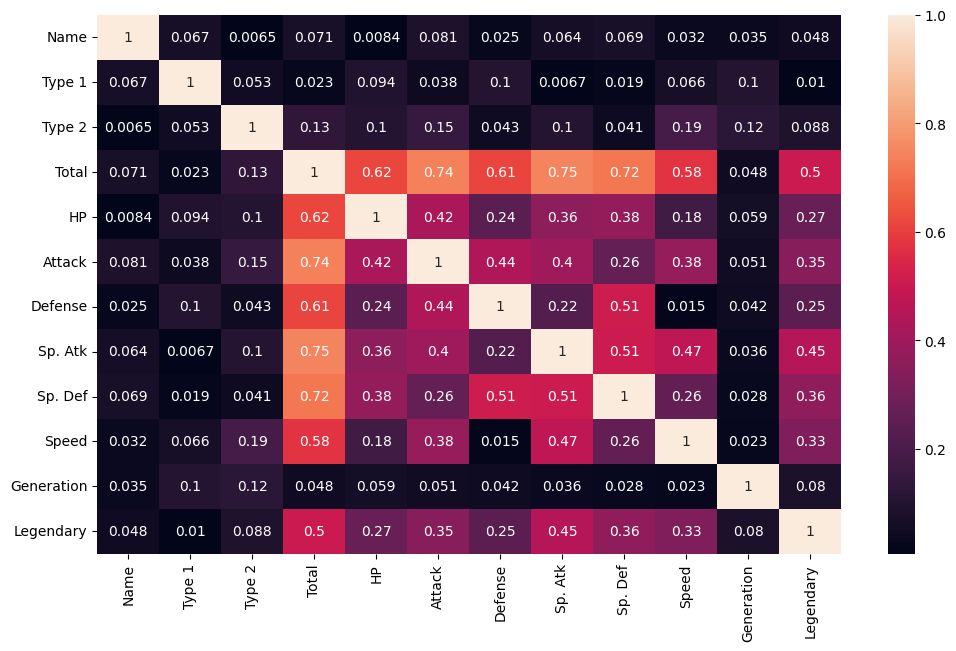

In [31]:
plt.figure(figsize=(12, 7))
sns.heatmap(abs(df.corr()), annot=True)

In [32]:
abs(df.corr()["Legendary"]).sort_values(ascending=False)

Legendary     1.000000
Total         0.501758
Sp. Atk       0.448907
Sp. Def       0.363937
Attack        0.345408
Speed         0.326715
HP            0.273620
Defense       0.246377
Type 2        0.087805
Generation    0.079794
Name          0.047575
Type 1        0.010162
Name: Legendary, dtype: float64

The columns with the highest correlation is "Total" and "Sp. Atk"

## Showing the ouliers on graphs

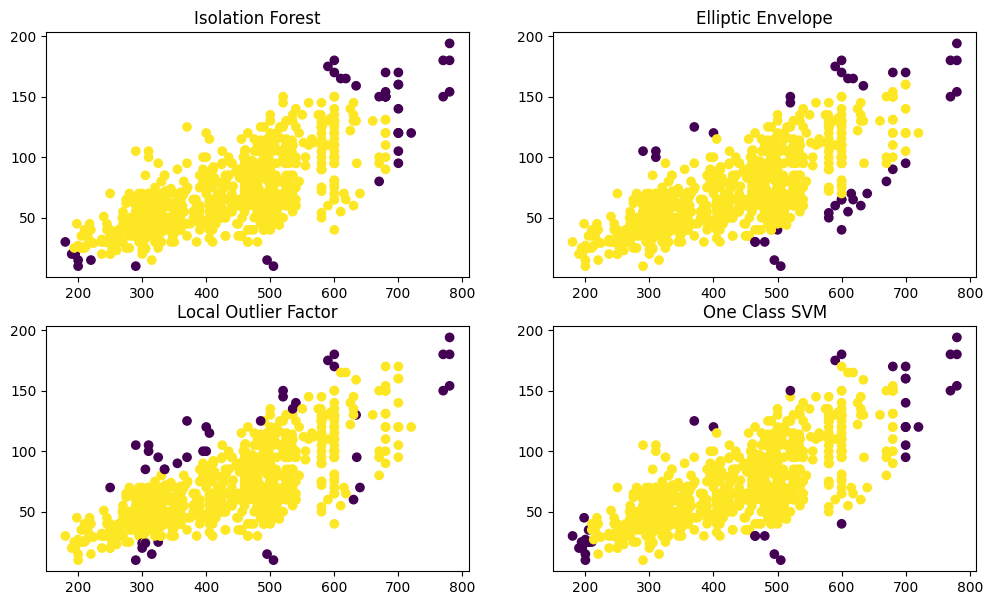

In [33]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

models = {
    "Isolation Forest": IsolationForest(contamination=0.05),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05),
    "Local Outlier Factor": LocalOutlierFactor(contamination=0.05),
    "One Class SVM": OneClassSVM(nu=0.05)
}

subset = df[["Total", "Sp. Atk"]]

predicitions = {}

for name, model in models.items():
    predicitions[name] = model.fit_predict(subset)

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

for ax, (name, preds) in zip(axes.flatten(), predicitions.items()):
    ax.scatter(subset["Total"], subset["Sp. Atk"], c=preds, cmap="viridis")
    ax.set_title(name)


I would say that looking at the results the best model is Isolation Forest but there may be different results with other datasets

## Contamination to number of outliers dependence

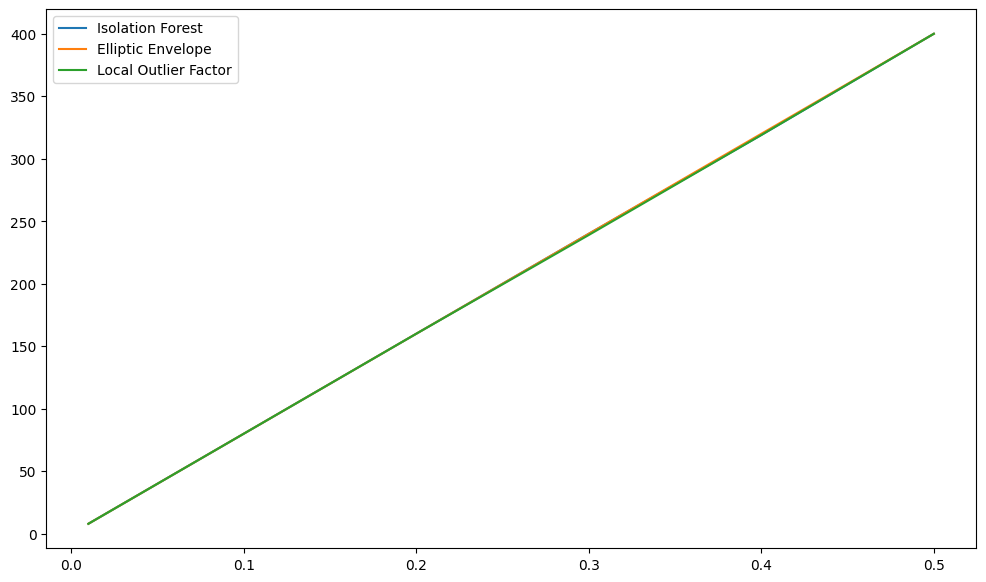

In [34]:
contamination_models = {
    "Isolation Forest": IsolationForest(),
    "Elliptic Envelope": EllipticEnvelope(),
    "Local Outlier Factor": LocalOutlierFactor()
}

values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(12, 7))

for name, model in contamination_models.items():

    n_outliers = []

    for value in values:

        model.set_params(contamination=value)
        outliers = model.fit_predict(subset)
        n_outliers.append(np.sum(outliers == -1))

    plt.plot(values, n_outliers, label=name)
plt.legend()

We can see that all 3 models show virtually the same line, because the contamination parameter shows the model how many outliers there are, so its natural that the number of outliers and the contamination value are proportional

## Model Training

In [44]:
X = df.drop(columns=["Legendary"])
y = df["Legendary"]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

outlier_models = {
    "Isolation Forest": IsolationForest(contamination=0.05),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05),
    "Local Outlier Factor": LocalOutlierFactor(contamination=0.05),
    "One Class SVM": OneClassSVM(nu=0.05),
    "No Outliers": None
}

estimators = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier()
}

results = {
    "Estimator": [],
    "Outlier": [],
    "Accuracy": []
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for outlier_name, outlier in outlier_models.items():
    if outlier is not None:
        X_train_no_outliers = X_train[outlier.fit_predict(X_train) == 1]
        y_train_no_outliers = y_train[outlier.fit_predict(X_train) == 1]
    elif outlier is None:
        X_train_no_outliers = X_train
        y_train_no_outliers = y_train

    for estimator_name, estimator in estimators.items():

        estimator.fit(X_train_no_outliers, y_train_no_outliers)
        score = accuracy_score(y_test, estimator.predict(X_test))

        results["Estimator"].append(estimator_name)
        results["Outlier"].append(outlier_name)
        results["Accuracy"].append(score)


results = pd.DataFrame(results)
results.sort_values("Accuracy", ascending=False)

,Estimator,Outlier,Accuracy
1,KNN,Isolation Forest,0.945833
5,KNN,Local Outlier Factor,0.945833
9,KNN,No Outliers,0.945833
7,KNN,One Class SVM,0.941667
3,KNN,Elliptic Envelope,0.937500
0,Logistic Regression,Isolation Forest,0.920833
2,Logistic Regression,Elliptic Envelope,0.920833
6,Logistic Regression,One Class SVM,0.916667
8,Logistic Regression,No Outliers,0.912500
4,Logistic Regression,Local Outlier Factor,0.908333


We can see that the best accuracy for both KNN and Logistic Regression is with Isolation Forest, making it likely the best Outlier Detection algorithm in this case. Considering this, all the cases are within 1% of eachother, so the difference is very small.